In [1]:
import time
import os, fnmatch
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Conv2DTranspose, BatchNormalization, UpSampling2D
from keras.regularizers import l2
import numpy.random as rand

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# create a list, result, of all file names
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

result = find('*.jpg', 'lfwfaces')
print("Number of images: " + str(len(result)))
print("Example file name: " + result[0])

Number of images: 13233
Example file name: lfwfaces/Aaron_Eckhart_0001.jpg


In [3]:
x_train = []

for i in range(len(result)):
    img = load_img(result[0])
    img = img_to_array(img)
    img = (img - 127.5) / 127.5
    x_train.append(img)
    
x_train = np.array(x_train)
print(x_train.shape)

(13233, 250, 250, 3)


In [4]:
# x_train = x_train[:1000]

def get_batch(size):
    
    arr = []
    
    for _ in range(size):
        
        k = rand.randint(0, 13233)
        arr.append(x_train[k])
    
    return np.array(arr)


In [5]:
# Generator

input_shape = (1, 1, 100)

generator = Sequential()

# conv2dTranspose layers to upsample
# generator.add(Conv2DTranspose(64,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(128,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(256,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(3,(5,5),strides=(2,2),activation='relu',input_shape=input_shape))
# generator.add(BatchNormalization())

generator.add(UpSampling2D(size=(5, 5), input_shape=input_shape)) # 100 x 5 x 5
generator.add(Conv2D(64,(2,2),activation='relu',padding='same')) # 64 x 5 x 5
# try adding strides=(2, 2)

generator.add(UpSampling2D(5)) # 64 x 25 x 25
generator.add(Conv2D(128,(2,2),activation='relu',padding='same')) # 128 x 25 x 25

generator.add(UpSampling2D(5)) # 128 x 125 x 125
generator.add(Conv2D(256,(2,2),activation='relu',padding='same')) # 256 x 125 x 125

generator.add(UpSampling2D(2)) # 256 x 250 x 250
generator.add(Conv2D(3,(2,2),activation='relu',padding='same')) # 3 x 250 x 250

# goal = 3 x 250 x 250

# Discriminator

img_shape = (250, 250, 3)

discriminator = Sequential()

discriminator.add(Conv2D(64,(10,10),activation='relu',input_shape=img_shape)) # 64x241x241 --> 64x120x120
discriminator.add(MaxPooling2D())
# try changing MaxPooling2D to AveragePooling2D

discriminator.add(Conv2D(128,(7,7),activation='relu', kernel_regularizer=l2(2e-4))) # 128x114x114 --> 128x57x57
discriminator.add(MaxPooling2D())

discriminator.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4))) # 256x54x54 --> 256x27x27 
discriminator.add(MaxPooling2D())

discriminator.add(Conv2D(512,(7,7),activation='relu',kernel_regularizer=l2(2e-4))) # 512x21x21 --> 512x10x10
discriminator.add(MaxPooling2D())

discriminator.add(Conv2D(1024,(10,10),activation='relu')) # 1024x1x1

discriminator.add(Flatten()) # (None, 1024)

discriminator.add(Dense(1,activation="sigmoid",kernel_regularizer=l2(1e-3))) # (None, 1)

In [6]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 5, 5, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          25664     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       32896     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 125, 125, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 256)     131328    
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 250, 250, 256)     0         
__________

In [7]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 241, 241, 64)      19264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 114, 114, 128)     401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 57, 57, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 54, 54, 256)       524544    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 512)       6423040   
__________

In [8]:
# GAN

# initially -- since we only want to train either the generator or discriminator at a time
discriminator.trainable = False

# gan input (noise) will be 100-dimensional vectors
gan_input = Input(shape=input_shape)

gan = Model(inputs = gan_input, outputs = discriminator(generator(gan_input)) )

gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [9]:
epochs = 30
batch_size = 10

for i in range(epochs):
    
    print("\n")
    print('-'*15, 'Epoch: ' + str(i), '-'*15)
    
    x_train_batch = get_batch(1000)
    # Number of batches
    batch_count = x_train_batch.shape[0] / batch_size
    
    start = 0
    end = batch_size
        
    for j in range(int(batch_count)):
        
        if j % 10 == 0 and j != 0:
            print(".", end="")
        
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])        
        image_batch = x_train_batch[start:end]
        image_batch = np.reshape(image_batch, (batch_size, 250, 250, 3))
        
        # Generate fake MNIST images
        generated_images = generator.predict(noise)
        # print(image_batch.shape)
        # print(generated_images.shape)
        X = np.concatenate([image_batch, generated_images])
        # generated_images.shape = (batch_size, 784), X.shape = (2 * batch_size, 784)

        # Labels for generated and real data
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 1

        # Train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])
        # The y-label will be 1 since we want to train the generator such that the GAN gives out 1
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)
        
        # Update start and end
        start += batch_size
        end += batch_size



--------------- Epoch: 0 ---------------


/home/arjung2/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


.........

--------------- Epoch: 1 ---------------
.........

--------------- Epoch: 2 ---------------
.........

--------------- Epoch: 3 ---------------
.........

--------------- Epoch: 4 ---------------
.........

--------------- Epoch: 5 ---------------
.........

--------------- Epoch: 6 ---------------
.........

--------------- Epoch: 7 ---------------
.........

--------------- Epoch: 8 ---------------
.........

--------------- Epoch: 9 ---------------
.........

--------------- Epoch: 10 ---------------
.........

--------------- Epoch: 11 ---------------
.........

--------------- Epoch: 12 ---------------
.........

--------------- Epoch: 13 ---------------
.........

--------------- Epoch: 14 ---------------
.........

--------------- Epoch: 15 ---------------
.........

--------------- Epoch: 16 ---------------
.........

--------------- Epoch: 17 ---------------
.........

--------------- Epoch: 18 ---------------
.........

--------------- Epoch: 19 ---------------
..

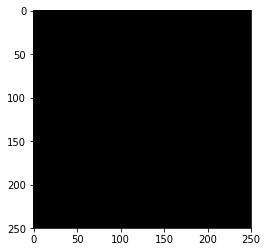

[0.5]


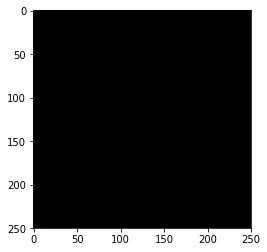

[0.5]


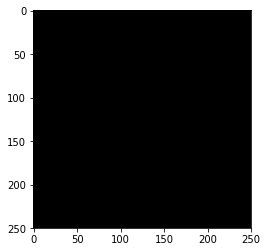

[0.5]


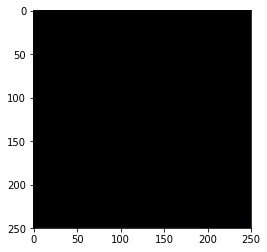

[0.5]


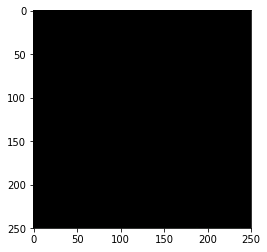

[0.5]


In [10]:
# Display a sample of the results
examples = 5
noise = np.random.normal(0, 1, size=[examples, 1, 1, 100])
generated_images = generator.predict(noise)
arr = discriminator.predict(generated_images)
generated_images = generated_images.reshape(examples, 250, 250, 3)
for k in range(examples):
    # plt.imshow(generated_images[k], interpolation='nearest', cmap='gray_r')
    # plt.imshow(generated_images[k], interpolation='nearest')
    plt.imshow(generated_images[k])
    plt.show()
    print(arr[k])